In [1]:
import sys
sys.path.append("/s/ls4/users/grartem/RL_robots/continuous-grid-arctic/")
sys.path.append("/s/ls4/users/grartem/RL_robots/RL_robotSim/")
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [2]:
os.chdir("/s/ls4/users/grartem/RL_robots/RL_robotSim/")

In [3]:
import time
import gym
import pyhocon
import numpy as np
import pandas as pd
import ray
from ray.rllib.agents.ppo.ppo import PPOTrainer
from ray.rllib.agents.ddpg.td3 import TD3Trainer
import pygame
import matplotlib.pyplot as plt
%matplotlib inline

import MyMisc

pygame 2.1.2 (SDL 2.0.16, Python 3.8.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Prepare env and model

In [4]:
configs = pyhocon.ConfigFactory.parse_file("/s/ls4/users/grartem/RL_robots/RL_robotSim/Configs/FollowerContinuous/PPO_obst.conf")
CONFIG = configs["ppo_env4_feats13v5"].as_plain_ordered_dict()
CONFIG["config"]["num_workers"]=1

In [5]:
CONFIG["config"]["env_config"]

OrderedDict([('name', 'Test-Cont-Env-Auto-v0'),
             ('base_env_config',
              OrderedDict([('add_obstacles', True),
                           ('warm_start', 0),
                           ('max_steps', 10000),
                           ('framerate', 5000),
                           ('obstacle_number', 35),
                           ('constant_follower_speed', False),
                           ('early_stopping',
                            OrderedDict([('max_distance_coef', 1.4),
                                         ('low_reward', -300)])),
                           ('random_frames_per_step', [2, 20]),
                           ('leader_speed_regime',
                            OrderedDict([('0', [0.2, 1]),
                                         ('200', 1),
                                         ('1000', [0.5, 1]),
                                         ('1500', 0.75),
                                         ('2000', 0),
                              

In [6]:
EXPERIMENT_DIR = "/s/ls4/users/grartem/RL_robots/RL_robotSim/results/FollowerContinuous/env4/PPO/feats/ppo_env4_feats13v5_bad/PPO_continuous-grid_59ca4_00000_0_2023-05-19_15-54-54/"
checkpoint_path = EXPERIMENT_DIR + "/checkpoint_000800/checkpoint-800"

In [7]:
trainer = ray.rllib.agents.registry.get_trainer_class(CONFIG["run"])(CONFIG["config"])
trainer.restore(checkpoint_path)

env = MyMisc.continuous_env_maker(config=CONFIG["config"]["env_config"])

(RolloutWorker pid=46883) pygame 2.1.2 (SDL 2.0.16, Python 3.8.0)
(RolloutWorker pid=46883) Hello from the pygame community. https://www.pygame.org/contribute.html
(RolloutWorker pid=46883) ===Запуск симуляции номер 0===


(RolloutWorker pid=46883) /s/ls4/users/grartem/RL_robots/continuous_grid_arctic/continuous_grid_arctic/follow_the_leader_continuous_env.py:331: UserWarning: Одновременно заданы и random_frames_per_step и frames_per_step, будет использоваться random_frames_per_step
(RolloutWorker pid=46883)   warn(
(RolloutWorker pid=46883) /s/ls4/users/grartem/anaconda3/envs/rl_robots/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=46883)   logger.warn(
(RolloutWorker pid=46883) Failed to create secure directory (/run/user/1556/pulse): No such file or directory
(RolloutWorker pid=46883) ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
(RolloutWorker pid=46883) ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
(RolloutWorker pid=46883) ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
(RolloutWorker pid=46883) ALSA lib conf.

In [8]:
policy = trainer.get_policy()
print(type(policy))
print(type(policy.model))

<class 'ray.rllib.agents.ppo.ppo_torch_policy.PPOTorchPolicy'>
<class 'ray.rllib.models.torch.visionnet.VisionNetwork'>


# Test episode

In [9]:
# Start env episode
seed_i = 0
env.seed(seed_i)
obs = env.reset()
done = False
total_reward = 0.0

===Запуск симуляции номер 0===


In [10]:
env.leader_positions_hist

deque([array([0., 0.]),
       array([19.77777778,  0.        ]),
       array([39.55555556,  0.        ]),
       array([59.33333333,  0.        ]),
       array([79.11111111,  0.        ]),
       array([98.88888889,  0.        ]),
       array([118.66666667,   0.        ]),
       array([138.44444444,   0.        ]),
       array([158.22222222,   0.        ]),
       array([178.,   0.])])

In [24]:
# run N steps
NNobs_history, raw_obs_history, reward_history, info_history, actions_hist = [], [], [], [], []
obs_history = []
start_time = time.time()
for i in range(10):
    # Compute a single action, given the current observation
    # from the environment.
    NNobs_history.append(obs)
    raw_obs = env.env.env._get_obs()
    raw_obs_history.append({
        #'LeaderTrackDetector_radar': raw_obs['LeaderTrackDetector_radar'],
        #'LeaderCorridor_lasers': raw_obs['LeaderCorridor_lasers']
        #'LeaderCorridor_lasers': raw_obs['LeaderCorridor_lasers']
        "numerical_features": raw_obs["numerical_features"]
    })
    
    action = trainer.compute_single_action(obs, explore=False)
    # Apply the computed action in the environment.
    #obs, reward, done, info = env.step(action)
    obs, reward, done, info = env.step([0.9, 0.0])
    obs_history.append(obs)
    
    actions_hist.append(action)
    reward_history.append(reward)
    info_history.append(info)
    # Sum up rewards for reporting purposes.
    total_reward += reward
elapsed_time = time.time() - start_time
elapsed_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
print(elapsed_time)

00:00:00


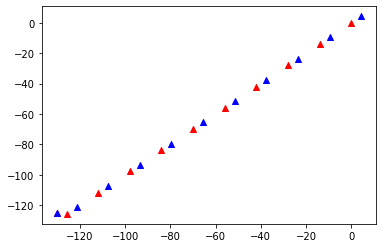

In [12]:
a = [np.array([0., 0.]), np.array([-13.98499891, -13.98499891]),
     np.array([-27.96999783, -27.96999783]), np.array([-41.95499674, -41.95499674]),
     np.array([-55.93999566, -55.93999566]), np.array([-69.92499457, -69.92499457]),
     np.array([-83.90999349, -83.90999349]), np.array([-97.8949924, -97.8949924]),
     np.array([-111.87999132, -111.87999132]), np.array([-125.86499023, -125.86499023]),
     np.array([-130.20569 , -125.534546])]
b = [np.array([4.39294434, 4.3928833 ]),
     np.array([-9.59205458, -9.59211561]),
     np.array([-23.57705349, -23.57711453]),
     np.array([-37.56205241, -37.56211344]),
     np.array([-51.54705132, -51.54711236]),
     np.array([-65.53205024, -65.53211127]),
     np.array([-79.51704915, -79.51711019]),
     np.array([-93.50204807, -93.5021091 ]),
     np.array([-107.48704698, -107.48710802]),
     np.array([-121.4720459 , -121.47210693]),
     np.array([-130.20569 , -125.534546])]
plt.scatter([x[0] for x in a], [x[1] for x in a] , marker="^", c="red")
plt.scatter([x[0] for x in b], [x[1] for x in b] , marker="^", c="blue")

plt.show()

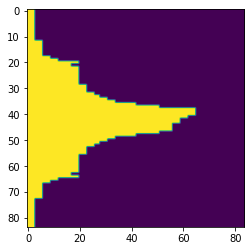

In [13]:
plt.imshow(obs[:,:,2]==1)

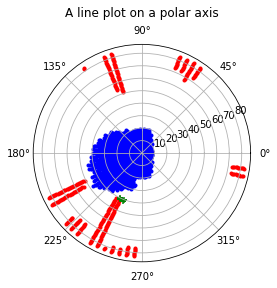

In [27]:
assert env.env.env.follower_sensors["LaserSensor"]["available_angle"]==360


fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
#ax.plot(theta, r)
#ax.set_rmax(2)
#ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
#ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line

for i in range(int(1 / env.map_wrapper_forgetting_rate)):
    if i<99:
        continue
    coords = np.where((obs[:,:,2]>(env.map_wrapper_forgetting_rate*i)) & (obs[:,:,2]<=(env.map_wrapper_forgetting_rate*(i+1))))
    r = coords[1]
    theta = coords[0] * (2*np.pi / obs.shape[0])
    ax.scatter(theta, r, c="blue", alpha=env.map_wrapper_forgetting_rate*(i+1), marker=".")

for i in range(int(1 / env.map_wrapper_forgetting_rate)):
    if i<99:
        continue
    coords = np.where((obs[:,:,0]>(env.map_wrapper_forgetting_rate*i)) & (obs[:,:,0]<=(env.map_wrapper_forgetting_rate*(i+1))))
    r = coords[1]
    theta = coords[0] * (2*np.pi / obs.shape[0])
    ax.scatter(theta, r, c="red", alpha=env.map_wrapper_forgetting_rate*(i+1), marker=".")


for i in range(int(1 / env.map_wrapper_forgetting_rate)):
    if i<98:
        continue
    coords = np.where((obs[:,:,1]>(env.map_wrapper_forgetting_rate*i)) & (obs[:,:,1]<=(env.map_wrapper_forgetting_rate*(i+1))))
    r = coords[1]
    theta = coords[0] * (2*np.pi / obs.shape[0])
    ax.scatter(theta, r, c="green", alpha=env.map_wrapper_forgetting_rate*(i+1), marker="+")
ax.grid(True)


ax.set_title("A line plot on a polar axis", va='bottom')
plt.show()


[1020.30249999  680.        ]


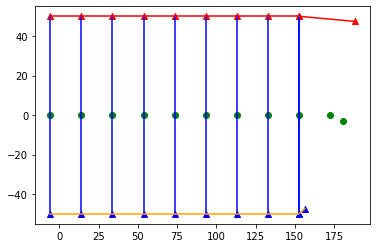

In [15]:
print(env.follower.position)
for i in range(len(env.corridor)-1):
    plt.plot([env.corridor[i][0][0], env.corridor[i][1][0]], [env.corridor[i][0][1], env.corridor[i][1][1]], c="blue")
    plt.plot([env.corridor[i][0][0], env.corridor[i+1][0][0]], [env.corridor[i][0][1], env.corridor[i+1][0][1]], c="red")
    plt.plot([env.corridor[i][1][0], env.corridor[i+1][1][0]], [env.corridor[i][1][1], env.corridor[i+1][1][1]], c="orange")
    #plt.plot([corridor[i+1][0][0], corridor[i+1][1][0]], [corridor[i+1][0][1], corridor[i+1][1][1]], "go--", c="green")
#plt.scatter([x[0] for x in obs["LaserSensor"][dotsInsideSafeZone,:]], [x[1] for x in obs["LaserSensor"][dotsInsideSafeZone,:]] , marker="+")
#plt.scatter([x[0] for x in obs["LaserSensor"][:,:]], [x[1] for x in obs["LaserSensor"][:,:]] , marker="+", alpha=0)
plt.scatter([x[0] for x in env.leader_positions_hist], [x[1] for x in env.leader_positions_hist] , marker="o", c="green")
plt.scatter([x[0][0] for x in env.corridor], [x[0][1] for x in env.corridor] , marker="^", c="red")

plt.scatter([x[1][0] for x in env.corridor], [x[1][1] for x in env.corridor] , marker="^", c="blue")

plt.show()

[1139.625  680.   ]
0 [False  True] [False  True] False
1 [False  True] [False  True] False
2 [False  True] [False  True] False
3 [False False] [False False] True
4 [False  True] [False  True] False
5 [ True  True] [ True  True] True
6 [ True  True] [ True  True] True
7 [False  True] [False  True] False
8 [False  True] [False  True] False
9 [False  True] [False  True] False
10 [False  True] [False  True] False


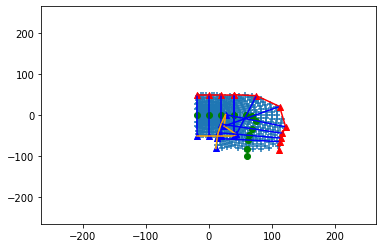

In [26]:
from continuous_grid_arctic.utils import wrappers
print(env.follower.position)
raw_obs = env.env.env._get_obs()
lidar_observation = raw_obs["LaserSensor"]
dotsInsideSafeZone = None
for i in range(len(env.corridor)-1):
    rectangle_points = [env.corridor[i][0], env.corridor[i][1],
                       env.corridor[i+1][0], env.corridor[i+1][1]]
    check1 = wrappers.areDotsOnLeft(np.array([rectangle_points[0], rectangle_points[3]]), np.array([rectangle_points[1], rectangle_points[2]]))
    check2 = wrappers.areDotsOnLeft(np.array([rectangle_points[1], rectangle_points[2]]), np.array([rectangle_points[3], rectangle_points[0]]))
    print(i, check1, check2, not ((check1==[False, True]).all() and (check2==[False, True]).all()))
    if ((check1==[False, True]).all() and (check2==[False, True]).all()):
        pass
    elif ((check1==[True, True]).all() and (check2==[True, True]).all()):
        rectangle_points[1], rectangle_points[3] = rectangle_points[3], rectangle_points[1]
    elif ((check1==[False, False]).all() and (check2==[False, False]).all()):
        rectangle_points[0], rectangle_points[2] = rectangle_points[2], rectangle_points[0]
    elif ((check1==[True, True]).all() and (check2==[False, False]).all()):
        rectangle_points[0], rectangle_points[1] = rectangle_points[1], rectangle_points[0]
    elif ((check1==[False, False]).all() and (check2==[True, True]).all()):
        rectangle_points[2], rectangle_points[3] = rectangle_points[3], rectangle_points[2]
    elif ((check1==[True, False]).all() and (check2==[True, False]).all()):
        rectangle_points[2], rectangle_points[3] = rectangle_points[3], rectangle_points[2]
        rectangle_points[0], rectangle_points[1] = rectangle_points[1], rectangle_points[0]
    else:
        raise ValueError("Не предвидел такой вариант расположения вершин прямоугольника (сегмента корридора) при проверке, находятся ли точки внутри него")
    # проверяем точки лидара на то, находятся ли они внутри этого прямоугольника или нет.
    
    line = np.array([rectangle_points[0], rectangle_points[1]])
    insideDots_currRectangle = wrappers.areDotsOnLeft(line, lidar_observation)
    line = np.array([rectangle_points[1], rectangle_points[3]])
    insideDots_currRectangle &= wrappers.areDotsOnLeft(line, lidar_observation)
    line = np.array([rectangle_points[3], rectangle_points[2]])
    insideDots_currRectangle &= wrappers.areDotsOnLeft(line, lidar_observation)
    line = np.array([rectangle_points[2], rectangle_points[0]])
    insideDots_currRectangle &= wrappers.areDotsOnLeft(line, lidar_observation)
    if i==0:
        dotsInsideSafeZone = insideDots_currRectangle
    else:
        dotsInsideSafeZone |= insideDots_currRectangle

for i in range(len(env.corridor)-1):
    plt.plot([env.corridor[i][0][0], env.corridor[i][1][0]], [env.corridor[i][0][1], env.corridor[i][1][1]], c="blue")
    plt.plot([env.corridor[i][0][0], env.corridor[i+1][0][0]], [env.corridor[i][0][1], env.corridor[i+1][0][1]], c="red")
    plt.plot([env.corridor[i][1][0], env.corridor[i+1][1][0]], [env.corridor[i][1][1], env.corridor[i+1][1][1]], c="orange")
    #plt.plot([corridor[i+1][0][0], corridor[i+1][1][0]], [corridor[i+1][0][1], corridor[i+1][1][1]], "go--", c="green")
plt.scatter([x[0] for x in raw_obs["LaserSensor"][dotsInsideSafeZone,:]], [x[1] for x in raw_obs["LaserSensor"][dotsInsideSafeZone,:]] , marker="+")
plt.scatter([x[0] for x in raw_obs["LaserSensor"][:,:]], [x[1] for x in raw_obs["LaserSensor"][:,:]] , marker="+", alpha=0)
plt.scatter([x[0] for x in env.leader_positions_hist], [x[1] for x in env.leader_positions_hist] , marker="o", c="green")
plt.scatter([x[0][0] for x in env.corridor], [x[0][1] for x in env.corridor] , marker="^", c="red")

plt.scatter([x[1][0] for x in env.corridor], [x[1][1] for x in env.corridor] , marker="^", c="blue")

plt.show()

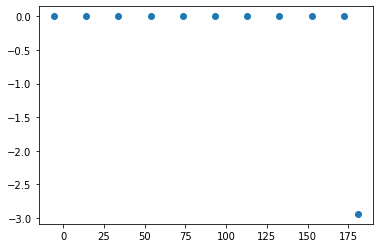

In [17]:
plt.scatter([x[0] for x in env.leader_positions_hist], [x[1] for x in env.leader_positions_hist])
plt.show()

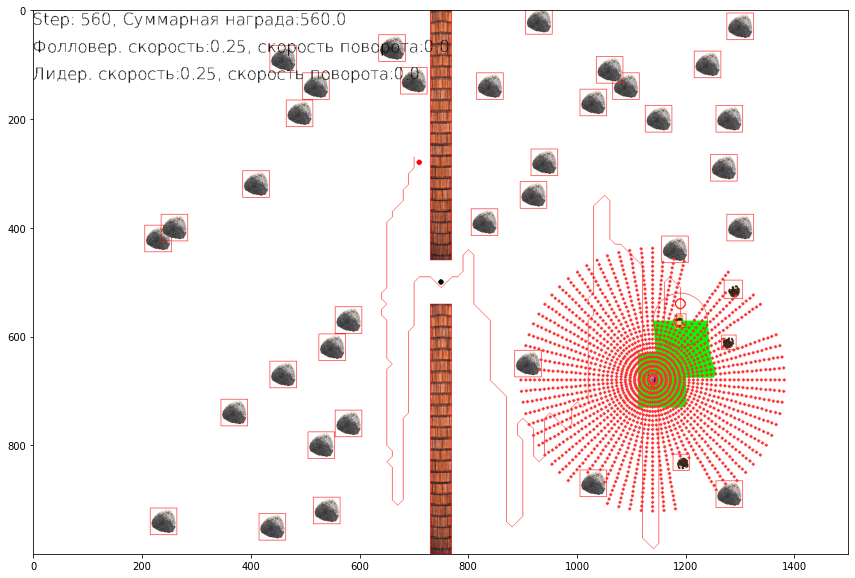

In [25]:
env.render()
plt.figure(figsize=(15,10))
plt.imshow(pygame.surfarray.array3d(env.gameDisplay).transpose((1,0,2)))

In [19]:
for i in range(len(raw_obs_history)):
    print("Raw observes:")
    print(raw_obs_history[i])
    print("NN inputs:")
    print(NNobs_history[i])
    print("Action:")
    print(actions_hist[i])
    print("Reward:")
    print(reward_history[i])
    print("Info:")
    print(info_history[i])
    print("#"*50)

Raw observes:
{'numerical_features': array([1190.,  680.,    0.,    0.,    0., 1012.,  680.,    0.,    0.,
          0.], dtype=float32)}
NN inputs:
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [1. 0. 0.]
  [1. 0. 0.]
  [1. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [1. 0. 0.]
  [1. 0. 0.]
  [1. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
Action:
[ 0.30623877 -3.6482642 ]
Reward:
1.0
Info:
{'mission_status': 'in_progress', 'agent_status': 'moving', 'leader_status': 'moving'}
##################################################
Raw observes:
{'numerical_features': array([1.1905452e+03, 6.7999695e+02, 6.8326421e-02, 3.5882703e+02,
       5.7296002e-01, 1.0120250e+03